In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [136]:
df = pd.read_csv("wowah_data.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   char        int64 
 1    level      int64 
 2    race       object
 3    charclass  object
 4    zone       object
 5    guild      int64 
 6    timestamp  object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09


In [137]:
df.rename(columns = lambda x: x.strip(), inplace = True)
print("AFTER LOAD:", df['char'].nunique(), df.shape)
df.columns

AFTER LOAD: 37354 (10826734, 7)


Index(['char', 'level', 'race', 'charclass', 'zone', 'guild', 'timestamp'], dtype='object')

In [138]:
df['timestamp'] = pd.to_datetime(
    df['timestamp'],
    errors='coerce',
    dayfirst=True,
    cache=True
)


print("AFTER PARSE:", df['char'].nunique(), df.shape)


/tmp/ipython-input-2855679118.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(


AFTER PARSE: 37354 (10826734, 7)


In [139]:
last_activity = df.groupby('char')['timestamp'].max()


In [140]:
print(last_activity)

char
2       2008-03-12 10:41:47
7       2008-12-28 23:06:41
9       2008-12-06 23:56:09
10      2008-12-10 12:15:55
19      2008-12-29 01:35:10
                ...        
90576   2008-12-31 23:07:13
90577   2008-12-31 22:47:54
90578   2008-12-31 22:32:52
90579   2008-12-31 22:44:45
90580   2008-12-31 23:15:20
Name: timestamp, Length: 37354, dtype: datetime64[ns]


In [141]:
df['timestamp'].min(), df['timestamp'].max()


(Timestamp('2008-01-01 00:02:04'), Timestamp('2008-12-31 23:50:18'))

In [142]:
X_DAYS = 30

OBS_END = df['timestamp'].max()
FEATURE_END = OBS_END - pd.Timedelta(days=X_DAYS)

last_activity = (
    df[df['timestamp'] <= FEATURE_END]
    .groupby('char')['timestamp']
    .max()
)

y = (
    (FEATURE_END - last_activity).dt.days >= X_DAYS
).astype(int)


print(y.mean())


0.6342216306533375


In [143]:
days_inactive = (FEATURE_END - last_activity).dt.days
thresholds = [7, 14, 21, 30]

churn_counts = {
    f"churn_{t}_days": (days_inactive >= t).sum()
    for t in thresholds
}

churn_table = pd.DataFrame.from_dict(
    churn_counts,
    orient="index",
    columns=["num_churners"]
)

churn_table

total_players = len(days_inactive)

churn_table["pct_churners"] = (
    churn_table["num_churners"] / total_players
)

churn_table


,num_churners,pct_churners
churn_7_days,29385,0.832177
churn_14_days,27409,0.776217
churn_21_days,25775,0.729943
churn_30_days,22395,0.634222


In [144]:
meta = df.groupby('char').agg(
    race=('race', 'first'),
    charclass=('charclass', 'first')
)

meta = meta.join(y.rename("churn"))


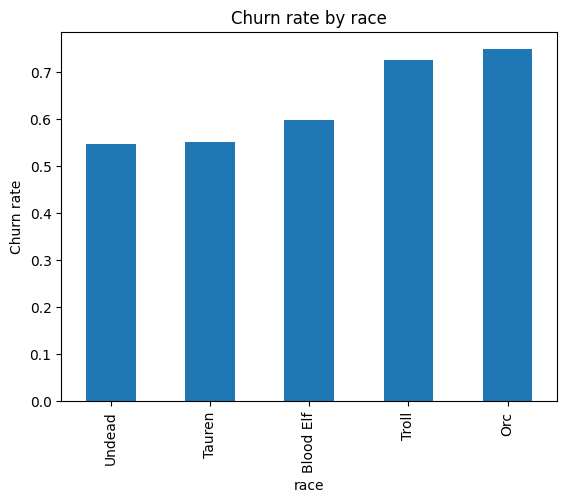

In [145]:
race_churn = meta.groupby('race')['churn'].mean().sort_values()

plt.figure()
race_churn.plot(kind='bar')
plt.ylabel("Churn rate")
plt.title("Churn rate by race")
plt.show()


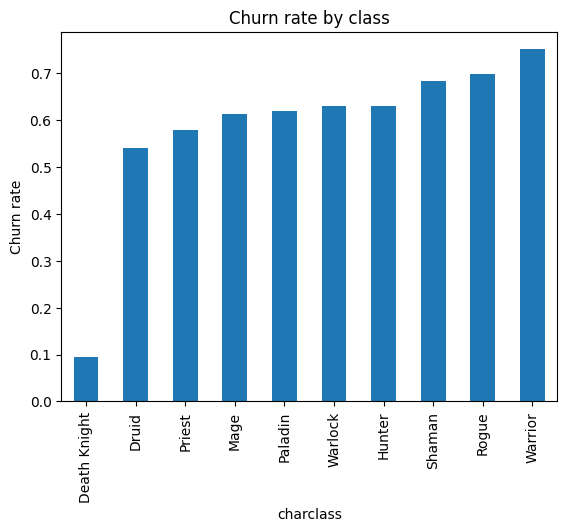

In [146]:
class_churn = meta.groupby('charclass')['churn'].mean().sort_values()

plt.figure()
class_churn.plot(kind='bar')
plt.ylabel("Churn rate")
plt.title("Churn rate by class")
plt.show()


In [147]:
race_churn.var(), class_churn.var()


(0.009311747048154365, 0.033009903088714015)

In [148]:
df_feat = df[df['timestamp'] <= FEATURE_END]


In [149]:
# Player-level guild membership flag
in_guild = (
    df_feat
    .groupby('char')['guild']
    .apply(lambda x: (x != -1).any())
    .astype(int)
    .rename('in_guild')
)


In [150]:
guild_churn_df = in_guild.to_frame().join(y.rename('churn'))


In [151]:
in_guild.value_counts()


,count
in_guild,
0,23616
1,11695


In [152]:
guild_churn_df = (
    in_guild
    .rename('in_guild')
    .to_frame()
    .join(y.rename('churn'))
)

print(guild_churn_df.columns)

churn_by_guild = guild_churn_df.groupby('in_guild')['churn'].mean()
print(churn_by_guild)



Index(['in_guild', 'churn'], dtype='object')
in_guild
0    0.764143
1    0.371868
Name: churn, dtype: float64


In [153]:
churn_by_guild.var()


0.07693969429277805

In [154]:
X = (
    df_feat
    .groupby('char')
    .agg(
        total_sessions=('timestamp', 'count'),
        max_level=('level', 'max')
    )
)


<Figure size 640x480 with 0 Axes>

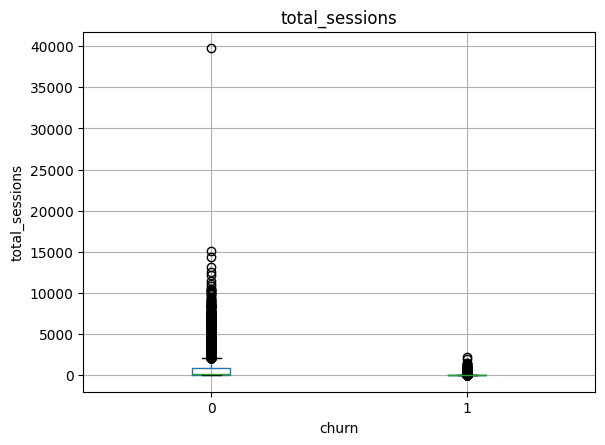

<Figure size 640x480 with 0 Axes>

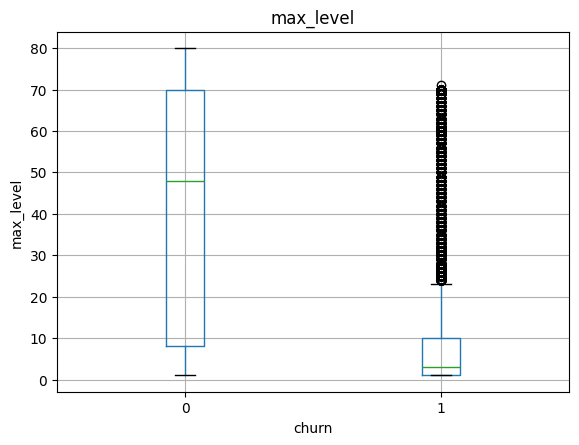

In [155]:
num_features = X.columns.tolist()

for col in num_features:
    plt.figure()
    X.join(y.rename("churn")).boxplot(column=col, by="churn")
    plt.title(col)
    plt.suptitle("")
    plt.xlabel("churn")
    plt.ylabel(col)
    plt.show()


In [156]:
X['total_sessions'] = np.log1p(X['total_sessions'])

print(X.columns.tolist())
print(X.describe())



['total_sessions', 'max_level']
       total_sessions     max_level
count    35311.000000  35311.000000
mean         2.826964     20.681063
std          2.228396     26.018740
min          0.693147      1.000000
25%          1.098612      1.000000
50%          2.079442      6.000000
75%          4.127134     33.000000
max         10.590818     80.000000


In [157]:
X.columns.tolist()


['total_sessions', 'max_level']

<Figure size 640x480 with 0 Axes>

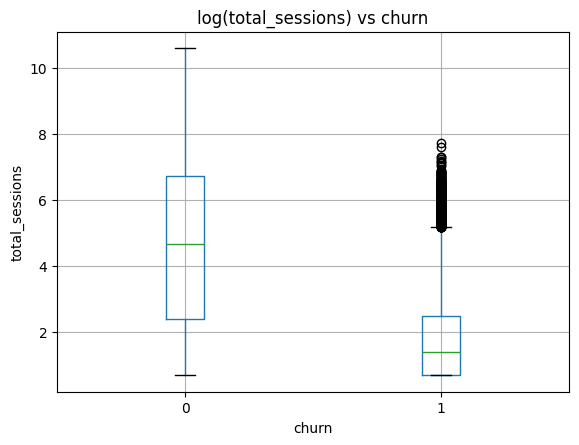

<Figure size 640x480 with 0 Axes>

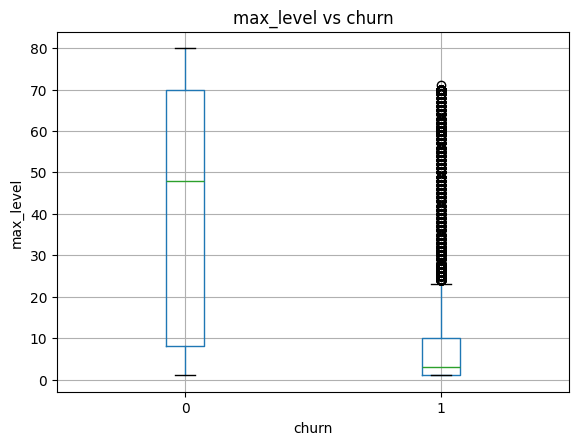

In [158]:
import matplotlib.pyplot as plt

plot_df = X.join(y.rename("churn"))

for col in X.columns:
    plt.figure()
    plot_df.boxplot(column=col, by="churn")

    if col == "total_sessions":
        plt.title("log(total_sessions) vs churn")
    else:
        plt.title(f"{col} vs churn")

    plt.suptitle("")
    plt.xlabel("churn")
    plt.ylabel(col)
    plt.show()


In [159]:
print(in_guild.value_counts())

in_guild
0    23616
1    11695
Name: count, dtype: int64


In [160]:
X_DAYS = 30
CUTOFF = OBS_END - pd.Timedelta(days=X_DAYS)

first_login = df[df['timestamp'] < CUTOFF].groupby('char')['timestamp'].min()
last_login  = df[df['timestamp'] < CUTOFF].groupby('char')['timestamp'].max()

active_span_days = (
    (last_login - first_login).dt.days + 1
).rename('active_span_days')

active_span_days = (
    active_span_days
    .reindex(y.index)
    .fillna(0)
    .astype(int)
)



In [161]:
print(active_span_days.describe())
print("Min value:", active_span_days.min())


count    35311.000000
mean       113.002605
std        135.602349
min          1.000000
25%          1.000000
50%          9.000000
75%        267.000000
max        336.000000
Name: active_span_days, dtype: float64
Min value: 1


<Figure size 640x480 with 0 Axes>

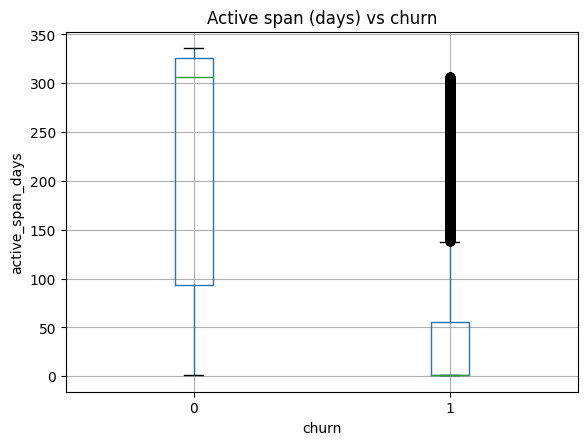

In [162]:
import matplotlib.pyplot as plt

plot_df = active_span_days.to_frame().join(y.rename("churn"))

plt.figure()
plot_df.boxplot(column="active_span_days", by="churn")
plt.title("Active span (days) vs churn")
plt.suptitle("")
plt.xlabel("churn")
plt.ylabel("active_span_days")
plt.show()


In [163]:
plot_df.groupby("churn")['active_span_days'].mean()


,active_span_days
churn,
0,226.880381
1,47.325207


In [164]:
CUTOFF = OBS_END - pd.Timedelta(days=X_DAYS)
df_pre = df[df['timestamp'] < CUTOFF]


In [165]:
num_zones = (
    df_pre
    .groupby('char')['zone']
    .nunique()
    .rename('num_zones')
)


In [166]:
num_zones = num_zones.reindex(y.index).fillna(0)


<Figure size 640x480 with 0 Axes>

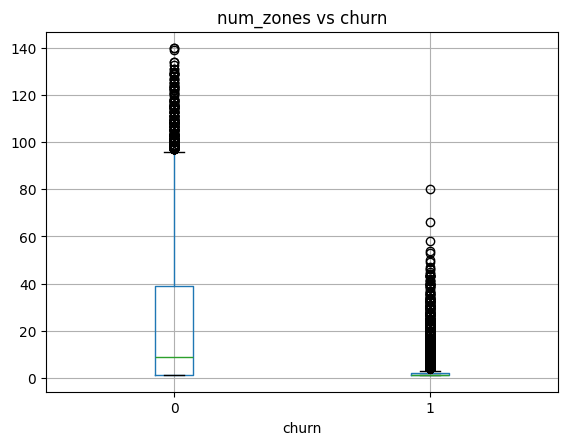

In [167]:
import matplotlib.pyplot as plt

plot_df = (
    pd.concat([num_zones, y.rename('churn')], axis=1)
)

for col in ['num_zones']:
    plt.figure()
    plot_df.boxplot(column=col, by='churn')
    plt.title(f"{col} vs churn")
    plt.suptitle("")
    plt.show()


In [168]:
comparison_df = (
    X
    .join(in_guild.rename('in_guild'))
    .join(num_zones.rename('num_zones'))
    .join(active_span_days.rename('active_span_days'))
    .join(y.rename('churn'))
)
comparison_df.corr()



,total_sessions,max_level,in_guild,num_zones,active_span_days,churn
total_sessions,1.000000,0.780708,0.600181,0.824279,0.824257,-0.589525
max_level,0.780708,1.000000,0.570174,0.746593,0.675900,-0.571997
in_guild,0.600181,0.570174,1.000000,0.536047,0.563983,-0.383313
num_zones,0.824279,0.746593,0.536047,1.000000,0.632222,-0.505932
active_span_days,0.824257,0.675900,0.563983,0.632222,1.000000,-0.637773
churn,-0.589525,-0.571997,-0.383313,-0.505932,-0.637773,1.000000


In [169]:
X = X.join(in_guild)

In [170]:
final_features = X.columns.tolist()
final_features


['total_sessions', 'max_level', 'in_guild']

In [171]:
print("Num features:", X.shape[1])
print("Any NaNs:", X.isna().any().any())
print("Label mean:", y.mean())


Num features: 3
Any NaNs: False
Label mean: 0.6342216306533375


In [172]:
print("df shape:", df.shape)
print("unique players:", df['char'].nunique())
print("X shape:", X.shape)
print("y shape:", y.shape)


df shape: (10826734, 7)
unique players: 37354
X shape: (35311, 3)
y shape: (35311,)


In [173]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=67,
    stratify=y
)


In [174]:
print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())


(28248, 3) (7063, 3)
0.6342041914471821 0.6342913776015857
